# TOKIO Dashboard Prototype

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
import os

In [2]:
import pandas
import numpy as np
import scipy
import scipy.stats as stats
import json
import datetime
import time
import textwrap
import warnings

In [3]:
### Relative path to the repository's root directory
_REPO_BASE_DIR = os.path.join('..', '..')

### Translates cryptic counter names into something suitable for labeling plots
_COUNTER_LABELS = json.load(open(os.path.join(_REPO_BASE_DIR, 'scripts', 'counter_labels.json'), 'r'))

In [4]:
### Variables which we wish to display on the UMAMI
### dashboard.  Keyed by variables to display, and the values
### indicate if a high value is good
_DEFAULT_ROW_PLOTS = { 
    'edison': [
        ('darshan_agg_perf_by_slowest_gibs', True),
        ('coverage_factor',                  True),
        ('nodehr_coverage_factor',           True),
        ('lmt_mds_ave',                      False),
        ('lmt_ops_opencloses',               False),
#       ('lmt_oss_max',                      False),
#       ('ost_avg_pct',                      False),
#       ('ost_bad_pct',                      False),
        ('job_max_radius',                   False),
#       ('job_concurrent_jobs',              False),
    ],
    'mira': [
        ('darshan_agg_perf_by_slowest_gibs', True),
        ('coverage_factor',                  True),
        ('iops_coverage_factor',             True),
        ('ggio_ops_opencloses',              False),
#       ('ggio_ops_rw',                      False),
        ('ggio_read_dirs',                   False),
    ],
}

In [31]:
### Some rendering parameters for the dashboard itself
_DASHBOARD_FONT_SIZE = 14
_DASHBOARD_LINE_WIDTH = 2
_DASHBOARD_HIGHLIGHT_COLORS = [ '#DA0017', '#FD6A07', '#40A43A', '#2C69A9' ]
_DASHBOARD_LINE_COLOR = '#853692'

## Load and refine data

Load both Edison and Mira data from CSVs and attach the MMDF data to Mira

In [32]:
### black magic necessary for processing Mira log files :(
try:
    import pytz
    _USE_TZ = True
except ImportError:
    _USE_TZ = False

def utc_timestamp_to_YYYYMMDD( timestamp ):
    """
    This is a batty function that allows us to compare the UTC-based
    timestamps from Darshan logs (start_time and end_time) to the
    Chicago-based YYYY-MM-DD dates used to index the mmdf data.
    """
    if _USE_TZ:
        ### we know that these logs are from Chicago
        tz = pytz.timezone("America/Chicago")
        
        ### Darshan log's start time in UTC, so turn it into a datetime with UTC on it
        darshan_time = pytz.utc.localize(datetime.datetime.utcfromtimestamp(timestamp))
        
        ### Then convert this UTC start time into a local start time so
        ### we can compare it to the local mmdf timestamp
        darshan_time_at_argonne = darshan_time.astimezone(tz)
        return darshan_time_at_argonne
    else:
        ### we assume that this script is running on Argonne time; it's the best we can do
        warnings.warn("pytz is not available so mmdf data might be misaligned by a day!")
        return datetime.datetime.fromtimestamp(timestamp)

In [33]:
### Edison
df_edison = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                   'data',
                                                   'dat',
                                                   'tokio-lustre',
                                                   'edison-abc-stats_2-14_3-28_v2.csv')).dropna()
df_edison['darshan_rw'] = [ 'write' if x == 1 else 'read' for x in df_edison['darshan_write_mode?'] ]
df_edison['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_edison['darshan_api'] ]
df_edison.rename(columns={'lmt_bytes_covered': 'coverage_factor'}, inplace=True)
df_edison['system'] = "edison"
df_edison['iops_coverage_factor'] = -1.0
df_edison['nodehr_coverage_factor'] = df_edison['job_num_nodes'] * \
                                      (df_edison['darshan_end_time'] - df_edison['darshan_start_time']) / 3600.0 / \
                                      (df_edison['job_concurrent_nodehrs'])

### Mira
df_mira = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'alcf-abc-stats_2-25_3-19.dat')).dropna()
rename_dict = { '# platform': "system" }
for key in df_mira.keys():
    if key == 'file_sys':
        rename_dict[key] = 'darshan_file_system'
    elif key not in rename_dict and not key.startswith('ggio_'):
        rename_dict[key] = 'darshan_' + key
df_mira.rename(columns=rename_dict, inplace=True)
df_mira['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_mira['darshan_api'] ]
df_mira['coverage_factor'] = df_mira['darshan_total_bytes'] / (df_mira['ggio_bytes_read'] + df_mira['ggio_bytes_written'])
df_mira['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))
df_mira['nodehr_coverage_factor'] = -1.0

In [34]:
df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'mira_mmdf_1-25_3-23.csv'),
                                        index_col=['file_system', 'date'])
df_mmdf['free_kib'] = df_mmdf['free_kib_blocks'] + df_mmdf['free_kib_frags']
df_mmdf['free_pct'] = df_mmdf['free_kib'] / df_mmdf['disk_size']

In [35]:
### I really hope iterrows behaves deterministically and preserves order...
new_data = {
    'mmdf_avg_fullness_pct': [],
    'mmdf_max_fullness_pct': [],
}

### iterate over each row of the master Mira dataframe
for row in df_mira.itertuples():
    fs_key = row.darshan_file_system
    mmdf_key = utc_timestamp_to_YYYYMMDD( row.darshan_start_time ).strftime("%Y-%m-%d")
    if mmdf_key in df_mmdf.loc[fs_key].index:
        ### only look at today's data
        df = df_mmdf.loc[fs_key].loc[mmdf_key]
        
        data_cols = [ True if x else False for x in df['data?'] ]

        ### calculate a percent fullness - don't bother saving the id of this fullest server though
        new_data['mmdf_max_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].min() )
        new_data['mmdf_avg_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].mean() )
    else:
        new_data['mmdf_max_fullness_pct'].append( np.nan )
        new_data['mmdf_avg_fullness_pct'].append( np.nan )

for new_col_name, new_col_data in new_data.iteritems():
    df_mira[new_col_name] = new_col_data

In [36]:
df = pandas.concat( (df_mira, df_edison) )

## Filter Data

In [37]:
df.drop(df.index[df['coverage_factor'] > 1.2], inplace=True)

df.drop(df.index[(df['system'] == 'mira') & (df['darshan_jobid'] == 1039807)], inplace=True)

## Synthesize new metrics and normalize data

In [38]:
df['darshan_agg_perf_by_slowest_gibs'] = df['darshan_agg_perf_by_slowest'] / 1024.0
df['lmt_ops_opencloses'] = df['lmt_ops_opens'] + df['lmt_ops_closes']
df['ggio_ops_opencloses'] = df['ggio_opens'] + df['ggio_closes']
df['ggio_ops_rw'] = df['ggio_read_reqs'] + df['ggio_write_reqs']

In [39]:
### Can also just add up all the MDS ops (of interest).
### Even though they are not weighted evenly in terms
### of cost on MDS, this is a rough approximation of
### activity since metadata rates are also bursty and
### probably don't overlap often.
for i in df.keys():
    if "_ops_" in i:
        if "lmt_ops_total" in df:
            df['lmt_ops_total'] += df[i]
        else:
            df['lmt_ops_total'] = df[i]
_COUNTER_LABELS['lmt_ops_total'] = "Server Metadata Ops"
_COUNTER_LABELS['lmt_ops_opencloses'] = "Server Open/Close Ops"
_COUNTER_LABELS['ggio_ops_opencloses'] = "Server Open/Close/Creat Ops"
_COUNTER_LABELS['ggio_ops_rw'] = "Server Read-Write Ops"
_COUNTER_LABELS['nodehr_coverage_factor'] = "Coverage Factor (Node Hours)"
_COUNTER_LABELS['coverage_factor'] = "Coverage Factor (Bandwidth)"

### Scale op counts to make them plottable:
for i in df.keys():
    if "_ops_" in i or i == "ggio_read_dirs":
        max_val = df[i].max()
        if max_val > 2e9:
            df[i] = df[i] / 1e9
            _COUNTER_LABELS[i] += " (GOps)"
            print "Scaling %s to GOps" % i
        elif max_val > 2e6:
            df[i] = df[i] / 1e6
            _COUNTER_LABELS[i] += " (MOps)"
            print "Scaling %s to MOps" % i
        elif max_val > 2e3:
            df[i] = df[i] / 1e3
            _COUNTER_LABELS[i] += " (KOps)"
            print "Scaling %s to KOps" % i

Scaling ggio_read_dirs to KOps
Scaling lmt_ops_closes to MOps
Scaling lmt_ops_getattrs to KOps
Scaling lmt_ops_getxattrs to KOps
Scaling lmt_ops_mkdirs to KOps
Scaling lmt_ops_opens to MOps
Scaling lmt_ops_renames to KOps
Scaling lmt_ops_setattrs to KOps
Scaling lmt_ops_unlinks to KOps
Scaling lmt_ops_opencloses to MOps
Scaling ggio_ops_opencloses to MOps
Scaling ggio_ops_rw to MOps


## Define what we want UMAMI to show us

In [54]:
### This list will contain the input parameters for each UMAMI we want to generate
umami_list = [
    ### For generating the "I/O contention" case study figure (v2)
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': None,
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'],

    },
    
    ### For generating the "I/O contention" case study figure (v2), piece by piece
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '0',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:1],
    },
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '1',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:2],
    },
        {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '2',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:3],
    },
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '3',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:4],
    },
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '4',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:5],
    },
    {
        'fs': 'scratch2',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '5',
        'highlight_index': -1,
        'other_filters': [
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['edison'][0:6],
    },

    ### For generating the "namespace contention" case study figure
    {
        'fs': 'mira-fs1',
        'app': 'VPIC-IO',
        'rw': 'write',
        'suffix': None,
        'highlight_index': -1,
        'other_filters': [
             (df['darshan_end_time'] >= time.mktime(datetime.datetime(2017,  3,  1,  0,  0,  0).timetuple())),
             (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3, 12,  0,  0,  0).timetuple())),
        ],
        'rows': _DEFAULT_ROW_PLOTS['mira'],
    },
    ### For generating the "storage capacity" case study figure
    {
        'fs': 'scratch3',
        'app': 'HACC-IO',
        'rw': 'write',
        'suffix': '-long-term',
        'highlight_index': -3,
        'other_filters': [
            (df['darshan_end_time'] >= time.mktime(datetime.datetime(2017,  2, 21,  0,  0,  0).timetuple())),
            (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3, 15,  0,  0,  0).timetuple())),
        ],
        'rows': [
            ('darshan_agg_perf_by_slowest_gibs', True),
            ('coverage_factor',                  True),
#           ('nodehr_coverage_factor',           True),
            ('lmt_oss_max',                      False),
            ('ost_max_pct',                      False),
        ],
    },
]

## Helper functions required to generate UMAMIs

In [55]:
def umami_filter(df, file_system, app, rw, other_filters=None):
    """
    Translates a few basic logical input parameters into a filtered dataframe
    """
    filter_list = []
    if file_system is not None:
        filter_list.append((df['darshan_file_system'] == file_system))
    if app is not None:
        filter_list.append((df['darshan_app'] == app))
    if rw is not None:
        filter_list.append((df["darshan_rw"] == rw))

    if other_filters is not None:
        filter_list = filter_list + other_filters
    ### Apply filters to cut down on the data we're going to present
    num_rows = len(df)
    print "Start with %d rows before filtering" % num_rows
    net_filter = [ True for i in range(len(df.index))]
    for idx, condition in enumerate(filter_list):
        ct = len( [ x for x in net_filter if x ] )
        net_filter &= condition
        num_drops = (ct - len( [ x for x in net_filter if x ] ))
        print "Dropped %d rows after filter #%d (%d left)" % (num_drops, idx, ct-num_drops)

    print "%d rows will be included in UMAMI" % len(df[net_filter].index)
    assert len(df[net_filter].index) > 0
    
    return df[net_filter].copy()

In [58]:
def generate_umami( df_plot, rows_to_plot, output_file=None, highlight_index=-1 ):
    fig = plt.figure()
    fig.set_size_inches(6, len(rows_to_plot) * 12.0 / 9.0)

    ### Required to adjust the column widths of our figure (width_ratios)
    gridspec = matplotlib.gridspec.GridSpec(len(rows_to_plot), 2, width_ratios=[4,1])

    last_ax_ts = None
    for idx, (plot_variable, big_is_good) in enumerate(rows_to_plot):
        def dt64todatetime(dt64):
            """
            the dataframe stores datetimes as np.datetime64,
            which is expressed in nanoseconds (1e9 seconds).  To
            convert this to a datetime.datetime object which we
            can transform in matplotlib, some amount of
            gymnastics is required.
            """
            return datetime.datetime.fromtimestamp(dt64.astype(int) * 1e-9)

        ### Cast all pandas times (numpy.datetime64) into Python datetimes
        x = [ datetime.datetime.fromtimestamp(x) for x in df_plot['darshan_end_time'].values ]
        y = df_plot[plot_variable].values

        ### first plot the timeseries of the given variable
        ax_ts = fig.add_subplot(gridspec[2*idx])
        ax_ts.plot(x, y,
                   linestyle='-',
                   marker='x',
                   linewidth=_DASHBOARD_LINE_WIDTH * 1.0,
                   color=_DASHBOARD_LINE_COLOR)

        # textwrap.wrap inserts line breaks into each label
        ax_ts.set_ylabel('\n'.join(textwrap.wrap(
                            text=_COUNTER_LABELS.get(plot_variable, plot_variable).replace('/', '-'),
                                width=15, break_on_hyphens=True)).replace('-', '/'),
                            fontsize=_DASHBOARD_FONT_SIZE,
                            rotation=0,
                            horizontalalignment='right',
                            verticalalignment='center'
                        )
        ax_ts.grid()

        # blank out the labels for all subplots except the bottom-most one
        if idx != len(rows_to_plot) - 1:
            ax_ts.set_xticklabels([])
        else:
            last_ax_ts = ax_ts
            # resize and rotate the labels for the timeseries plot
            for tick in ax_ts.xaxis.get_major_ticks():
                tick.label.set_fontsize(1.15 * _DASHBOARD_FONT_SIZE) 
                tick.label.set_rotation(45)

        # also adjust the font size for the y labels
        for tick in ax_ts.yaxis.get_major_ticks():
            tick.label.set_fontsize(1.15 * _DASHBOARD_FONT_SIZE)

        ### then plot the boxplot summary of the given variable
        ax_box = fig.add_subplot(gridspec[2*idx+1])
        boxp = ax_box.boxplot(y[0:-1], ### note: do not include last measurement in boxplot
                       widths=0.70,
                       boxprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                       medianprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                       whiskerprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                       capprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                       flierprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                       whis=[5,95])

        # scale the extents of the y ranges a little for clarity
        orig_ylim = ax_ts.get_ylim()
        new_ylim = map(lambda a, b: a*(1 + b), orig_ylim, (-0.1, 0.1))
        ax_ts.set_ylim(new_ylim)
        
        yticks = ax_ts.get_yticks().tolist()
        
        # the following is a heuristic to determine how close the topmost
        # tick label is to the edge of the plot.  if it's too close, blank
        # it out so it doesn't overlap with the bottom-most tick label
        # of the row above it
        critical_fraction = abs(1.0 - (yticks[-1] - new_ylim[0]) / (new_ylim[-1] - new_ylim[0]))
        if idx > 0 and critical_fraction < 0.01:
            ### note that setting one of the yticks to a string resets the
            ### formatting so that the tick labels appear as floats.  since
            ### we (hopefully) would get integral ticks otherwise, force
            ### them to ints.  This will mess things up if the yrange is
            ### very narrow and must be expressed as floats.
            yticks = map(int, yticks)
            yticks[-1] = " "
            ax_ts.set_yticklabels(yticks)
                        
        # lock in the y range to match the timeseries plot, just in case
        ax_box.set_ylim(ax_ts.get_ylim())

        # determine the color of our highlights based on quartile
        percentiles = [ np.percentile(y[0:-1], percentile) for percentile in 25, 50, 75, 100 ]
        for color_index, percentile in enumerate(percentiles):
            if y[-1] <= percentile:
                break
        if big_is_good:
            highlight_color = _DASHBOARD_HIGHLIGHT_COLORS[color_index]
        else:
            highlight_color = _DASHBOARD_HIGHLIGHT_COLORS[(1+color_index)*-1]

        # highlight the latest measurement on the timeseries plot
        x_last = matplotlib.dates.date2num(x[highlight_index])
        x_2nd_last = matplotlib.dates.date2num(x[highlight_index-1])
        ax_ts.plot([x_2nd_last, x_last],
                   [y[highlight_index-1], y[highlight_index]],
                   linestyle='-',
                   color=highlight_color,
                   linewidth=2.0 * _DASHBOARD_LINE_WIDTH)
        ax_ts.plot([x_last], [y[highlight_index]],
                   marker='*',
                   color=highlight_color,
                   markersize=15)

        # where does this last data point lie on the distribution?
        ax_box.plot([0,2],
                    [y[highlight_index],y[highlight_index]],
                    linestyle='--',
                    color=highlight_color,
                    linewidth=2.0 * _DASHBOARD_LINE_WIDTH,
                    zorder=10)

        # blank out all labels
        ax_box.set_yticklabels([""])
        ax_box.set_xticklabels([""])
        ax_box.yaxis.grid()

    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.autofmt_xdate()
    last_ax_ts.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

    if output_file is not None:
        fig.savefig(output_file, bbox_inches="tight")
        print "Saved %s" % output_file

## FINALLY generate the actual UMAMIs

Generating umami-scratch2-hacc-write.pdf
Start with 1178 rows before filtering
Dropped 812 rows after filter #0 (366 left)
Dropped 274 rows after filter #1 (92 left)
Dropped 46 rows after filter #2 (46 left)
Dropped 26 rows after filter #3 (20 left)
20 rows will be included in UMAMI
Saved umami-scratch2-hacc-write.pdf
Generating umami-scratch2-hacc-write0.pdf
Start with 1178 rows before filtering
Dropped 812 rows after filter #0 (366 left)
Dropped 274 rows after filter #1 (92 left)
Dropped 46 rows after filter #2 (46 left)
Dropped 26 rows after filter #3 (20 left)
20 rows will be included in UMAMI
Saved umami-scratch2-hacc-write0.pdf
Generating umami-scratch2-hacc-write1.pdf
Start with 1178 rows before filtering
Dropped 812 rows after filter #0 (366 left)
Dropped 274 rows after filter #1 (92 left)
Dropped 46 rows after filter #2 (46 left)
Dropped 26 rows after filter #3 (20 left)
20 rows will be included in UMAMI
Saved umami-scratch2-hacc-write1.pdf
Generating umami-scratch2-hacc-write

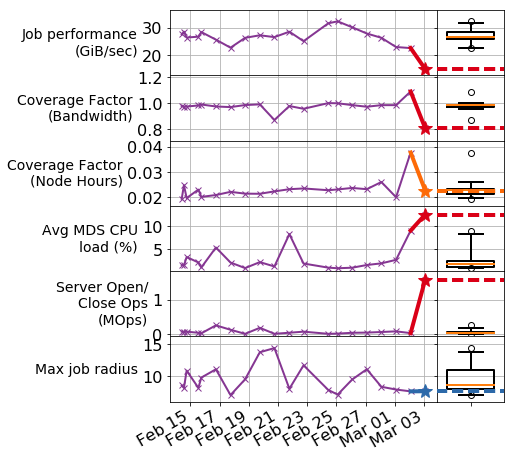

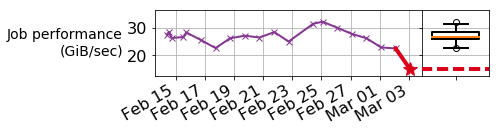

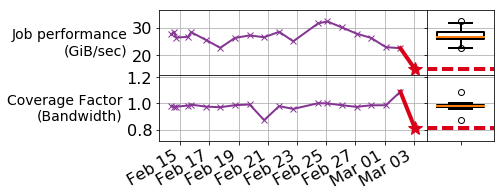

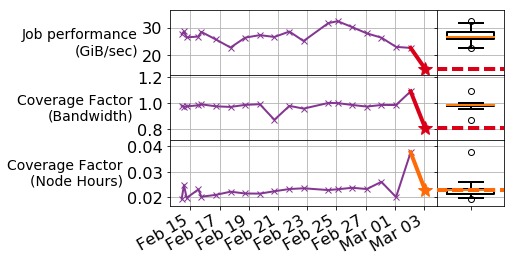

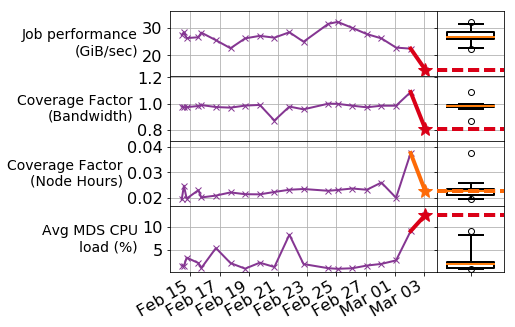

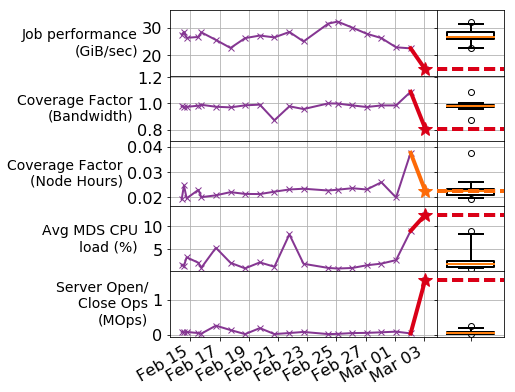

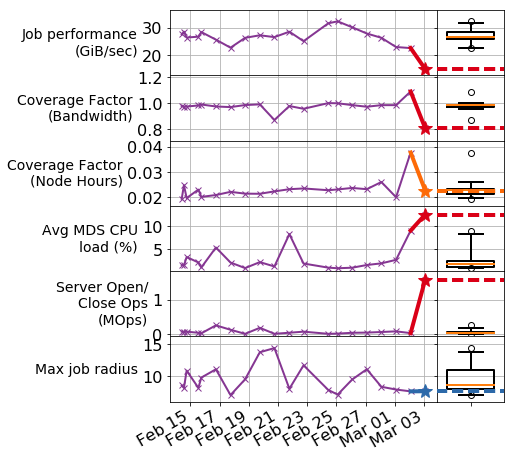

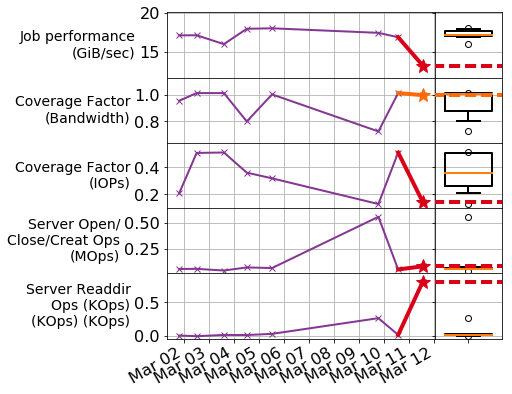

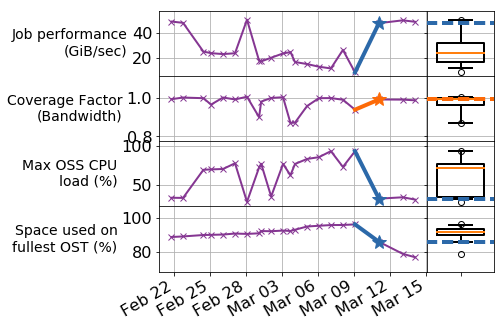

In [59]:
for umami_config in umami_list:

    output_file = "umami-%s-%s-%s%s.pdf" % (
        umami_config['fs'],
        umami_config['app'].replace('-IO', '').lower(),
        umami_config['rw'], 
        umami_config['suffix'] if umami_config['suffix'] is not None else ""
    )
    print "Generating %s" % output_file
    ### Apply the filters we defined above to get a dataframe suitable for UMAMI
    df_plot = umami_filter(df,
                           umami_config['fs'],
                           umami_config['app'],
                           umami_config['rw'],
                           umami_config['other_filters'])

    generate_umami(df_plot, 
                   umami_config['rows'],
                   output_file=output_file,
                   highlight_index=umami_config['highlight_index'] )